In [1]:
# default_exp core

# Core

> Helper functions used throughout the library.

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#hide
from nbdev.showdoc import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
#export
from fastcore.all import *
from fastai2.torch_imports import *
from fastai2.torch_core import *
from fastai2.data.all import *

In [5]:
#export
from timeseries.imports import *
from timeseries.utils import *

In [7]:
#export
class TSTensor(TensorBase):
    '''Returns a tensor of at least 2 dims of type torch.float32 and class TSTensor'''
    def __new__(cls, o, dtype=torch.float32, **kwargs): 
        res = ToType(dtype)(To2DPlusTensor(o))
        res.__class__ = cls
        res._meta = kwargs
        return res

    @property
    def vars(self): return self.shape[-2]

    @property
    def len(self): return self.shape[-1]
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def __repr__(self):
        if self.ndim >= 3:   return f'TSTensor(samples:{self.shape[-3]}, vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 2: return f'TSTensor(vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 1: return f'TSTensor(len:{self.shape[-1]})'
        else: return f'TSTensor(float)'

    def show(self, ax=None, ctx=None, title=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold')
        plt.tight_layout()
        return ax

@Transform
def ToTSTensor(o:np.ndarray, dtype=torch.float32, **kwargs): 
    """ Transforms input to tensor of dtype torch.float32"""
    return TSTensor(o, dtype=dtype, **kwargs)

TSTensor(vars:2, len:10)

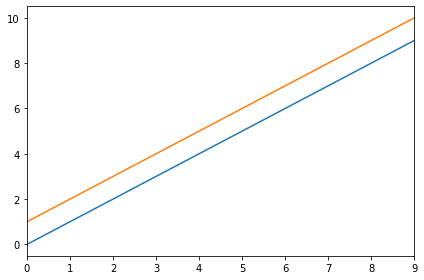

In [8]:
a = ToTSTensor(np.array([np.arange(10),np.arange(1,11)]))
a.show()
a

In [9]:
#export
class NumpyTensor(TensorBase):

    def __new__(cls, o, **kwargs): 
        res = ToTensor(o)
        res.__class__ = cls
        res._meta = kwargs
        return res
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def show(self, ax=None, ctx=None, title=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold')
        plt.tight_layout()
        return ax

@Transform
def ToNumpyTensor(o:np.ndarray): 
    return NumpyTensor(o)

What is the difference between `TSTensor` and `NumpyTensor`? Why make both?

In [10]:
#export
def TSTensorBlock(): 
    return TransformBlock(item_tfms=ToTSTensor)

class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_numpy(cls, X, y=None, splitter=None, valid_pct=0.2, seed=0, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from arrays (X and y, unless unlabeled)"
        if splitter is None: splitter = RandomSplitter(valid_pct=valid_pct, seed=seed)
        getters = [ItemGetter(0), ItemGetter(1)] if y is not None else [ItemGetter(0)]
        dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                           getters=getters,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)

        source = itemify(X) if y is None else itemify(X,y)
        return cls.from_dblock(dblock, source, **kwargs)

In [ ]:

class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path(cls, X, y=None, splitter=None, valid_pct=0.2, seed=0, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from arrays (X and y, unless unlabeled)"
        if splitter is None: splitter = RandomSplitter(valid_pct=valid_pct, seed=seed)
        getters = [ItemGetter(0), ItemGetter(1)] if y is not None else [ItemGetter(0)]
        dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                           getters=getters,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)

        source = itemify(X) if y is None else itemify(X,y)
        return cls.from_dblock(dblock, source, **kwargs)
    

In [11]:
# export 
@delegates(plt.subplots)
def show_tuple(tup, ax=None, **kwargs):
    "Display a timeseries plot from a tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], ax=ax, **kwargs)

In [12]:
# export
from fastai2.vision.data import get_grid

@typedispatch
@delegates(plt.subplots)
def show_batch(x:TSTensor, y:TensorCategory, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x.shape[0], max_n), add_vert=1, **kwargs)
    for tup, c, i in zip(samples, ctxs, range(max_n)):
        show_tuple(tup, ax=c)
    plt.tight_layout()

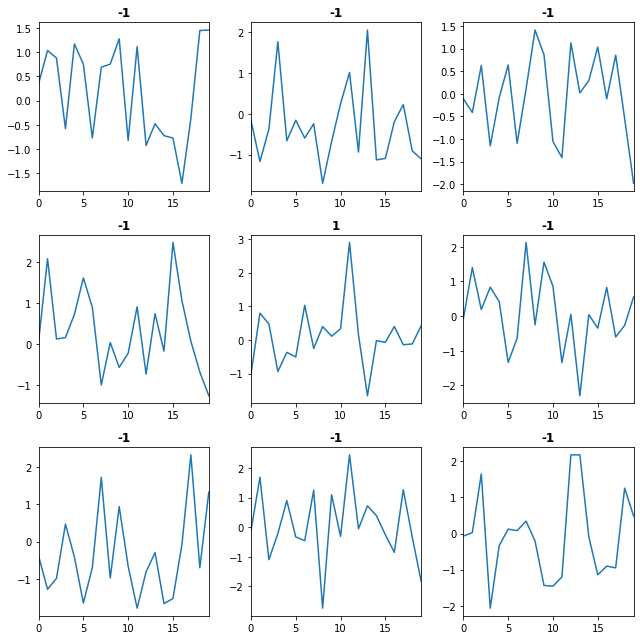

In [13]:
num_samples, length = 300, 20
y = np.random.choice([-1,1],[num_samples])
x = np.random.randn(300,length)
dls = TSDataLoaders.from_numpy(x,y = y)
dls.show_batch(max_n = 9)

In [14]:
#export
class NumpyDatasets(FilteredBase):
    "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs):
        super().__init__(dl_type=dl_type)

        #New 4 lines of code
        if tls is None:
            if items is None: items = itemify(X,) if y is None else itemify(X,y)
            assert (tfms is None or len(items[0]) == len(tfms)), f"n_tfms ({len(tfms)}) doesn't match n_items ({len(items[0])})"
            tfms = None if tfms is None else [[ItemGetter(i)] + L(tfms[i]) for i in range(len(items[0]))]
        
        self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp

    def __getitem__(self, it):
        res = tuple([tl[it] for tl in self.tls])
        return res if is_indexer(it) else list(zip(*res))

    def __getattr__(self,k): return gather_attrs(self, k, 'tls')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
    def __len__(self): return len(self.tls[0])
    def __iter__(self): return (self[i] for i in range(len(self)))
    def __repr__(self): return coll_repr(self)
    def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp)
    def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    def overlapping_splits(self): return self.tls[0].overlapping_splits()
    @property
    def splits(self): return self.tls[0].splits
    @property
    def split_idx(self): return self.tls[0].tfms.split_idx
    @property
    def items(self): return self.tls[0].items
    @items.setter
    def items(self, v):
        for tl in self.tls: tl.items = v

    def show(self, o, ctx=None, **kwargs):
        for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
        return ctx

    def new_empty(self):
        tls = [tl._new([], split_idx=tl.split_idx) for tl in self.tls]
        return type(self)(tls=tls, n_inp=self.n_inp)

    @contextmanager
    def set_split_idx(self, i):
        old_split_idx = self.split_idx
        for tl in self.tls: tl.tfms.split_idx = i
        yield self
        for tl in self.tls: tl.tfms.split_idx = old_split_idx

In [15]:
#export
def add_data(dsets, X=None, y=None, test_items=None, rm_tfms=None, with_labels=False):
    "Create a test or unlabeled sets from `items` using validation transforms of `dsets`"
    items = itemify(X,) if y is None else itemify(X, y)
    if y is None: with_labels = False
    else: with_labels = True
    if isinstance(dsets, (Datasets, NumpyDatasets)):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = [tl._new(items, split_idx=1) for tl in tls]
        if rm_tfms is None: rm_tfms = [tl.infer_idx(get_first(items)) for tl in new_tls]
        else:               rm_tfms = tuplify(rm_tfms, match=new_tls)
        for i,j in enumerate(rm_tfms): new_tls[i].tfms.fs = new_tls[i].tfms.fs[j:]
        if isinstance(dsets, Datasets):return Datasets(tls=new_tls)
        else: return NumpyDatasets(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        if rm_tfms is None: rm_tfms = dsets.infer_idx(get_first(items))
        new_tl.tfms.fs = new_tl.tfms.fs[rm_tfms:]
        return new_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data.Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

NumpyDatasets.add_data = add_data

In [75]:
#export
class TSTfmdDL(TfmdDL): 

    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def len(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        if b is None: b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if nrows is None: 
            sqrt = math.sqrt(len(db))
            rows = min(math.ceil(sqrt), len(db)) 
        if ncols is None: ncols = len(db) // rnows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(db[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()): 
            show_tuple(tup, ax=ax)
        plt.tight_layout()

    def test_dl(self:DataLoaders, test_items, rm_type_tfms=None, with_labels=False, **kwargs):
        "Create a test dataloader from `test_items` using validation transforms of `dls`"
        test = test_set(self.valid, test_items, rm_tfms=rm_type_tfms, with_labels=with_labels
                        ) if isinstance(self.valid, (Datasets, NumpyDatasets, TfmdLists)) else test_items
        return self.valid.new(test, **kwargs)



In [12]:
#hide
from save_nb import *
from nbdev.export import notebook2script
from fastcore.test import test_eq
save_nb()
notebook2script()
test_eq(last_saved() < 10, True)

<IPython.core.display.Javascript object>


Current notebook saved.

Converted 000_utils.ipynb.
Converted 001_core.ipynb.
Converted 002_data.ipynb.
Converted 100_layers.ipynb.
Converted 101_ResNet.ipynb.
Converted 102_InceptionTime.ipynb.
Converted index.ipynb.

core.py                        saved          0 s ago
utils.py                       saved          0 s ago
data.py                        saved          0 s ago
ResNet.py                      saved          0 s ago
InceptionTime.py               saved          0 s ago
layers.py                      saved          0 s ago

Total elapsed time 1 s
21-03-2020 16:49:15
